#  <center>Przetwarzanie i analiza danych w języku Python</center>

## <center>Projekt zaliczeniowy 2018/2019 (CSZ PW)</center>



# <center>ETAP I</center>

## <center>Import bibliotek</center>

In [1]:
import os
import numpy as np
import pandas as pd
import xml.etree.cElementTree as et
import copy
autoscroll = True
pd.set_option("display.notebook_repr_html", False)

## <center>Wczytywanie plików XML</center>

### <center>Funkcja zamieniająca plik XML na ramkę pandas.DataFrame</center>

In [2]:
def WczytajXML_jako_DF(NazwaXMLDok):
    """Wczytanie pliku XML o odpowiednim formacie
    1 root, 1 child, gdzie child wyglada:
    "b'<row Class="3" Date="2011-06-21T20:16:48.910" Id="1" Name="Autobiographer" TagBased="False" UserId="2" />\n  '"
    
    Args:
        NazwaXMLDok: String - nazwa pliku XML

    Returns:
        Pandas.DataFrame z danymi

    """
    #niezbedne biblioteki
    import numpy as np
    import pandas as pd
    import xml.etree.cElementTree as et
    
    print("Wczytuje plik XML o nazwie:", NazwaXMLDok)

    XMLDocument = et.parse( NazwaXMLDok ) #wczytanie XML w postaci 'drzewa'

    NazwyKolumn=list(XMLDocument.getroot()[0].attrib.keys()) # Pobiera dostepne nazwy elementow z pierwszego elementu (1st child)
    
    #Skanowanie drzewa XML w poszukiwaniu dodatkowych kolumn, ktorych nie ma w pierwszym elemencie
    for node in XMLDocument.getroot():
        for Kol in list(node.attrib.keys()):
            if Kol not in NazwyKolumn:
                NazwyKolumn.append(Kol)
    
    Wartosci=[]
    for i in NazwyKolumn: # inicjalizacja pustej listy, zawierajacej listy z wartosciami
        Wartosci.append([]) # kolejnych elementow

    Dane=dict.fromkeys(NazwyKolumn) #inicjalizacja slownika, gdzie klucze to nazwy elementow, a wartosci to listy z wartosciami
                                     # wszystkich elementow

    #Dla kazdej nazwy kolumny
    for Nazwa in NazwyKolumn: 

        #Odczytaj wartosci ze wszystkich wierszy (elementow)
        for node in XMLDocument.getroot():
            
            #!!! Uwaga. nie moze byc 2 takich samych nazw kolumn, bo list.index("nazwa") pokaze tylko pierwszy index.
            # Dodaj wartosc odpowiadajaca nazwie kolumny do listy z wartosciami
            Wartosci[NazwyKolumn.index(Nazwa)].append(node.attrib.get(NazwyKolumn[NazwyKolumn.index(Nazwa)])) 

    #dopisanie do slownika z danymi wartosci do odpowiednich kluczy (listy z wartosciami do nazw kolumn)
    for i in range(0,len(Dane)):
        Dane[NazwyKolumn[i]]=Wartosci[i]

    #Stworzenie Ramki Danych
    RamkaDanych=pd.DataFrame(Dane)
    print ("-------------------------------------------------------------------------------")
    return RamkaDanych

## <center>Czyszczenie Danych</center>


### <center>Funkcje Pomocnicze</center>

In [3]:
#Czyszczenie danych
 # Argument fk

#Funkcja sprawdzaja czy wartosc jest int
def is_int(s):
    if (s == True) or (s == False):    #zeby nie rzutowalo bool na int/float. w sumie to nie potrzebne
        return False
    try: 
        int(s)       #Sprobuj rzutowania na int. 
        return True   #zwroc True jesli sie uda
    except ValueError:
        return False  #zwroc False jesli sie NIE uda

#Funkcja sprawdzaja czy wartosc jest float, Analogicznie do powyzej
def is_float(s):
    if (s == True) or (s == False):    #zeby nie rzutowalo bool na int/float. w sumie to nie potrzebne
        return False
    try: 
        float(s)
        return True
    except ValueError:
        return False
    
#Funkcja sprawdzaja czy wartosc jest bool, Analogicznie do powyzej    
def is_bool(s):
    if (s == "False") or (s == "True"): 
        return True
    else:
        return False

#Funkcja sprawdzaja czy wartosc jest Timestamp, Analogicznie do powyzej    
def is_timestamp(s):
    if type(s) == pd._libs.tslibs.timestamps.Timestamp :
        return True
    else:
        return False

        

### <center>Funkcja Czyszczaca</center>

In [4]:
def Wyczysc_DF(Ramka):
    """Sprawdzenie czy kolumny zawieraja int/float/bool/date. Jesli tak, to castowanie na odpowiedni typ


    Args:
        Ramka: Pandas.DataFrame przeznaczony do wyczysczenia

    Returns:
        PandasDataFrame juz wyczyszczona 

    """
    #niezbedne biblioteki
    import numpy as np
    import pandas as pd
    #sprawdz wszystkie kolumny
    for NumerKolumny in range(0, len(Ramka.columns)):
        idx=0
        
        #Jesli pierwszy wiersz danej kolumny jest None (XML) albo Nan (.csv) - szukaj az do konkretnej wartosci string
        if (Ramka.iloc[ 0, NumerKolumny] == None) or (pd.isna(Ramka.iloc[ 0, NumerKolumny])):
            idx=Ramka.iloc[:,NumerKolumny].first_valid_index()
   
    #Sprawdzenie typu 
    
        if is_timestamp (Ramka.iloc[ idx, NumerKolumny]): #trzeba sprawdzic, bo is_int, itp. sie wykrzacza na timestampie
            continue
            
        elif is_int (Ramka.iloc[ idx, NumerKolumny]):  #czy pierwszy wyraz ze sprawdzanej kolumny jest 'int'

            Ramka.iloc[:,NumerKolumny] = pd.to_numeric(Ramka.iloc[:,NumerKolumny],downcast='integer') #cast calej kolumny na int
            print ("Zamieniono wartosci kolumny", Ramka.columns[NumerKolumny] , "na int (", type(Ramka.iloc[:,NumerKolumny][0]),")")
            continue   #zeby nie zamienilo int na floaty

        elif is_float (Ramka.iloc[ idx, NumerKolumny]):  #czy pierwszy wyraz ze sprawdzanej kolumny jest 'float'

            Ramka.iloc[:,NumerKolumny] = pd.to_numeric(Ramka.iloc[:,NumerKolumny],downcast='float')#cast calej kolumny na int
            print ("Zamieniono wartosci kolumny", Ramka.columns[NumerKolumny] ,"na float (", type(Ramka.iloc[:,NumerKolumny][0]),")")
            continue

        elif is_bool (Ramka.iloc[ idx, NumerKolumny]):  #czy pierwszy wyraz ze sprawdzanej kolumny jest 'bool'

            Ramka.iloc[:,NumerKolumny] = Ramka.iloc[:,NumerKolumny].replace(["False", "True"],[False, True])
            print ("Zamieniono wartosci kolumny", Ramka.columns[NumerKolumny] ,"na bool (", type(Ramka.iloc[:,NumerKolumny][0]),")")
            continue

        elif "Date" in Ramka.columns[NumerKolumny] :   #czy nazwa kolumny nazywa sie Date - wartosciami sa daty
            Ramka.iloc[:,NumerKolumny] = pd.to_datetime(Ramka.iloc[:,NumerKolumny])
            print ("Zamieniono format kolumny", Ramka.columns[NumerKolumny] ,"na format daty (", type(Ramka.iloc[:,NumerKolumny][0]),")")
            continue
    print ("-------------------------------------------------------------------------------")
    return Ramka

## <center>Operacje na plikach</center>

In [5]:
# %%capture    # <- nie wyswietla outputu
NazwyPlikow = ["Badges", "Comments", "PostHistory", "PostLinks", "Posts", "Tags", "Users", "Votes"]

XML=dict.fromkeys(NazwyPlikow) # dict z dictow zeby sie latwo operowalo


for Plik in NazwyPlikow:
    XML[Plik]=WczytajXML_jako_DF(Plik + ".xml")   # Wczytanie pliku XML
    XML[Plik]=Wyczysc_DF(XML[Plik])               # Wyczysczenie pliku
    XML[Plik].to_csv(Plik + ".csv", index= False, line_terminator='\r\n')               # Eksport do .csv

Wczytuje plik XML o nazwie: Badges.xml
-------------------------------------------------------------------------------
Zamieniono wartosci kolumny Id na int ( <class 'numpy.int32'> )
Zamieniono wartosci kolumny UserId na int ( <class 'numpy.int32'> )
Zamieniono format kolumny Date na format daty ( <class 'pandas._libs.tslibs.timestamps.Timestamp'> )
Zamieniono wartosci kolumny Class na int ( <class 'numpy.int8'> )
Zamieniono wartosci kolumny TagBased na bool ( <class 'numpy.bool_'> )
-------------------------------------------------------------------------------
Wczytuje plik XML o nazwie: Comments.xml
-------------------------------------------------------------------------------
Zamieniono wartosci kolumny Id na int ( <class 'numpy.int32'> )
Zamieniono wartosci kolumny PostId na int ( <class 'numpy.int32'> )
Zamieniono wartosci kolumny Score na int ( <class 'numpy.int16'> )
Zamieniono format kolumny CreationDate na format daty ( <class 'pandas._libs.tslibs.timestamps.Timestamp'> )
Za

## <center>Wynik Etapu I  (.info + .head(1) )</center>

In [6]:
for Plik in list(XML.keys()):
    
    Nr=list(XML.keys()).index(Plik)  # iteracja
    kreska= "---------------------------------" # do printa    
    
    print('\n', kreska, Nr,".", Plik, "- info", kreska,'\n')
    print(XML[Plik].info())
    print('\n', kreska,Nr,".",  Plik, "- head", kreska,'\n')
    print(XML[Plik].head(1))
  


 --------------------------------- 0 . Badges - info --------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143255 entries, 0 to 143254
Data columns (total 6 columns):
Id          143255 non-null int32
UserId      143255 non-null int32
Name        143255 non-null object
Date        143255 non-null datetime64[ns]
Class       143255 non-null int8
TagBased    143255 non-null bool
dtypes: bool(1), datetime64[ns](1), int32(2), int8(1), object(1)
memory usage: 3.6+ MB
None

 --------------------------------- 0 . Badges - head --------------------------------- 

   Id  UserId            Name                    Date  Class  TagBased
0   1       2  Autobiographer 2011-06-21 20:16:48.910      3     False

 --------------------------------- 1 . Comments - info --------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203462 entries, 0 to 203461
Data columns (total 7 columns):
Id                 203462 non-null int32
PostId             20

# <center>ETAP II</center>

## <center>Wczytanie plików</center>

In [7]:
# %%capture    # <- nie wyswietla outputu

NazwyPlikow = ["Badges", "Comments", "PostHistory", "PostLinks", "Posts", "Tags", "Users", "Votes"]

CSV=dict.fromkeys(NazwyPlikow) # dict z dictow zeby sie latwo operowalo


for Plik in NazwyPlikow:
    kreska= "---------------------------------" # do printa    
    
    print('\n', kreska, "Wczytuje plik :", Plik + ".csv", kreska,'\n')
    CSV[Plik]=pd.read_csv(Plik + ".csv")      # Wczytanie pliku .csv
    CSV[Plik]=Wyczysc_DF(CSV[Plik])               # Wyczysczenie pliku
             


 --------------------------------- Wczytuje plik : Badges.csv --------------------------------- 

Zamieniono wartosci kolumny UserId na int ( <class 'numpy.int32'> )
Zamieniono format kolumny Date na format daty ( <class 'pandas._libs.tslibs.timestamps.Timestamp'> )
Zamieniono wartosci kolumny Class na int ( <class 'numpy.int8'> )
-------------------------------------------------------------------------------

 --------------------------------- Wczytuje plik : Comments.csv --------------------------------- 

Zamieniono format kolumny CreationDate na format daty ( <class 'pandas._libs.tslibs.timestamps.Timestamp'> )
Zamieniono wartosci kolumny UserId na int ( <class 'numpy.float64'> )
-------------------------------------------------------------------------------

 --------------------------------- Wczytuje plik : PostHistory.csv --------------------------------- 

Zamieniono wartosci kolumny PostHistoryTypeId na int ( <class 'numpy.int8'> )
Zamieniono format kolumny CreationDate na fo

## <center>Zapytania SQL</center>

### <center>Stworzenie bazy danych SQL</center>

In [8]:
# SQLite
import sqlite3 # import SQLlite
conn = sqlite3.connect("travelexchangebaza.sqlite")  # stworzenie i polaczenie z baza danych

for Plik in list(CSV.keys()): #Dodanie do bazy SQL danych ze wszystkich DataFrame
    CSV[Plik].to_sql(Plik, conn, if_exists = 'replace' )
    print("Dodano", Plik, "do bazy danych SQL")

Dodano Badges do bazy danych SQL
Dodano Comments do bazy danych SQL
Dodano PostHistory do bazy danych SQL
Dodano PostLinks do bazy danych SQL
Dodano Posts do bazy danych SQL
Dodano Tags do bazy danych SQL
Dodano Users do bazy danych SQL
Dodano Votes do bazy danych SQL


### <center>Zadania z etapu II</center>
*a)Poprzez zapytanie SQL,
*b) Poprzez metody pandas. / pandas.DataFrame/ pandas. Series

#### Zad.1
10 najbardziej popularnych tagów stworzonych przez "żywych" użytkowników serwisu

1 a) Zapytanie z użyciem języka SQL

In [9]:
pd.read_sql_query("""
SELECT
Tags.TagName,
Tags.Count,
Posts.OwnerUserId,
Users.Location,
Users.DisplayName
FROM Tags
JOIN Posts ON Posts.Id=Tags.WikiPostId
JOIN Users ON Users.Id=Posts.OwnerUserId
WHERE OwnerUserId != -1
ORDER BY Count DESC
LIMIT 10
""", conn)

                   TagName  Count  OwnerUserId  \
0                      usa   3838         26.0   
1                       uk   3283         26.0   
2                 schengen   2810        140.0   
3  customs-and-immigration   2573        108.0   
4                  transit   1613       4171.0   
5                passports   1269       1375.0   
6          indian-citizens   1269        140.0   
7                   trains   1252         26.0   
8                   canada   1098        101.0   
9                  luggage   1041       4995.0   

                             Location     DisplayName  
0              Oxford, United Kingdom       Gagravarr  
1              Oxford, United Kingdom       Gagravarr  
2                      Oaxaca, Mexico     hippietrail  
3                          London, UK  Ankur Banerjee  
4               Giv'at Shmuel, Israel     Ari Brodsky  
5                              Kuwait   Burhan Khalid  
6                      Oaxaca, Mexico     hippietrail  
7

1 b) Zapytanie z użyciem biblioteki 'Pandas'

In [10]:
( 
CSV["Tags"].merge(CSV["Posts"], left_on='WikiPostId', right_on="Id")      # łączenie DF Tags i Posts
.merge(CSV["Users"], left_on='OwnerUserId', right_on='Id')                # łączenie DF Tags+Posts i Users
.query('OwnerUserId != -1')                                               # Zywi Uzytkownicy
.loc[:,["TagName","Count","OwnerUserId","Location","DisplayName"]]        # Lokalizacja wymaganych kolumn
.sort_values('Count', ascending=False).reset_index(drop=True).head(10)    # Sortowanie malejaco. top 10.
)

                   TagName  Count  OwnerUserId  \
0                      usa   3838         26.0   
1                       uk   3283         26.0   
2                 schengen   2810        140.0   
3  customs-and-immigration   2573        108.0   
4                  transit   1613       4171.0   
5          indian-citizens   1269        140.0   
6                passports   1269       1375.0   
7                   trains   1252         26.0   
8                   canada   1098        101.0   
9                  luggage   1041       4995.0   

                             Location     DisplayName  
0              Oxford, United Kingdom       Gagravarr  
1              Oxford, United Kingdom       Gagravarr  
2                      Oaxaca, Mexico     hippietrail  
3                          London, UK  Ankur Banerjee  
4               Giv'at Shmuel, Israel     Ari Brodsky  
5                      Oaxaca, Mexico     hippietrail  
6                              Kuwait   Burhan Khalid  
7

#### Zad.2
Ile głosów "za" (up-votes) ma każdy post  !Uwaga: specjalnie ignorujemy kolumnę Posts.Score

2 a) Zapytanie z użyciem języka SQL

In [11]:
pd.read_sql_query("""
SELECT
PostId,
COUNT(*) AS UpVotes
FROM Votes
WHERE VoteTypeId=2
GROUP BY PostId
""", conn).head(10)

   PostId  UpVotes
0       1       10
1       2       36
2       3       15
3       4        9
4       5       13
5       6       81
6       7        6
7       8       15
8       9       15
9      10      145

2 b) Zapytanie z użyciem biblioteki 'Pandas'

In [12]:
( 
CSV["Votes"].loc[CSV["Votes"]["VoteTypeId"]==2]                            # Tylko wiersze, gdzie VoteTypeId==2
.groupby("PostId").size().rename("UpVotes").to_frame().reset_index()       # Zliczenie glosow i zamiana nazwy 
).head(10)


   PostId  UpVotes
0       1       10
1       2       36
2       3       15
3       4        9
4       5       13
5       6       81
6       7        6
7       8       15
8       9       15
9      10      145

#### Zad.3
Tytuły i miary jakości całkiem popularnych i lubianych pytań

3 a) Zapytanie z użyciem języka SQL

In [13]:
pd.read_sql_query("""
SELECT
Title,
Score,
ViewCount,
FavoriteCount
FROM Posts
WHERE PostTypeId=1 AND FavoriteCount >= 25 AND ViewCount>=10000
""", conn).head(10)


                                               Title  Score  ViewCount  \
0  When traveling to a country with a different c...    144    20498.0   
1         How can I do a "broad" search for flights?    104    41853.0   
2  Tactics to avoid getting harassed by corrupt p...    172    15981.0   
3                       How to avoid drinking vodka?    158    16880.0   
4  Flight tickets: buy two weeks before even duri...    121    57749.0   
5  OK we're all adults here, so really, how on ea...    321    86389.0   
6  Why are one-way plane tickets more expensive t...     57    29409.0   
7  Japanese etiquette: Most common (and offensive...     62    29988.0   
8  Is it possible to make a decent income from tr...     57    10189.0   
9  Why are airline passengers asked to lift up wi...    220   124734.0   

   FavoriteCount  
0           38.0  
1           55.0  
2           46.0  
3           32.0  
4           41.0  
5           82.0  
6           25.0  
7           29.0  
8           40

3 b) Zapytanie z użyciem biblioteki 'Pandas'

In [14]:
(
CSV["Posts"].query("PostTypeId == 1  and FavoriteCount>=25 and ViewCount>=10000") #tylko posty zgodnie z wymogwami
.loc[:,["Title", "Score","ViewCount", "FavoriteCount"]].reset_index(drop=True)    #Tylko odpowiednie kolumny
).head(10) 

                                               Title  Score  ViewCount  \
0  When traveling to a country with a different c...    144    20498.0   
1         How can I do a "broad" search for flights?    104    41853.0   
2  Tactics to avoid getting harassed by corrupt p...    172    15981.0   
3                       How to avoid drinking vodka?    158    16880.0   
4  Flight tickets: buy two weeks before even duri...    121    57749.0   
5  OK we're all adults here, so really, how on ea...    321    86389.0   
6  Why are one-way plane tickets more expensive t...     57    29409.0   
7  Japanese etiquette: Most common (and offensive...     62    29988.0   
8  Is it possible to make a decent income from tr...     57    10189.0   
9  Why are airline passengers asked to lift up wi...    220   124734.0   

   FavoriteCount  
0           38.0  
1           55.0  
2           46.0  
3           32.0  
4           41.0  
5           82.0  
6           25.0  
7           29.0  
8           40

#### Zad.4
10 najczęściej poruszanych zagadnień (często użytkownicy zadają nowe pytania, na które już udzielono
odpowiedzi, wówczas społeczność tworzy odpowiednie odnośniki między pytaniami)

4 a) Zapytanie z użyciem języka SQL

In [15]:
pd.read_sql_query("""
SELECT
Posts.Title,
RelatedTab.NumLinks
FROM (
SELECT
RelatedPostId AS PostId,
COUNT(*) AS NumLinks
FROM PostLinks
GROUP BY RelatedPostId
) AS RelatedTab
JOIN Posts ON RelatedTab.PostId=Posts.Id
WHERE Posts.PostTypeId=1
ORDER BY NumLinks DESC
LIMIT 10

""", conn)


                                               Title  NumLinks
0  Is there a way to find out if I need a transit...       850
1  Do I need a visa to transit (or layover) in th...       809
2  Should I submit bank statements when applying ...       443
3  Should my first trip be to the country which i...       404
4  I have two passports/nationalities. How do I u...       268
5  UK visa refusal on V 4.2 a + c (and sometimes ...       265
6            How does the Schengen 90/180 rule work?       246
7  How much electronics and other valuables can I...       229
8  Do I need a US visa to transit (or layover) th...       200
9  Schengen Visa Refusal: Justification for the p...       174

4 b) Zapytanie z użyciem biblioteki 'Pandas'

In [16]:
# Stworzenie RelatedTab
RelatedTab = ( 
CSV["PostLinks"].groupby("RelatedPostId").size()  #liczenie relatedpostID
.rename("NumLinks").to_frame().reset_index() 
)
RelatedTab = RelatedTab.rename(columns = {"RelatedPostId" : "PostId"}) # Zamiana NAzwy kolumny
RelatedTab

# odczytanie postow
(
RelatedTab.merge(CSV["Posts"], left_on = "PostId", right_on = "Id")   # Łączenie RelatedTab z Posts
.query("PostTypeId == 1")                                             # Wybranie wierszy gdzie PostTypeId == 1
.loc[:, ["Title","NumLinks"]]                                         # Wybranie Kolumns Title i Numlinks
.sort_values("NumLinks", ascending=False).reset_index(drop=True)      # sortowanie 
.head(10)                                                             # top10
)


                                               Title  NumLinks
0  Is there a way to find out if I need a transit...       850
1  Do I need a visa to transit (or layover) in th...       809
2  Should I submit bank statements when applying ...       443
3  Should my first trip be to the country which i...       404
4  I have two passports/nationalities. How do I u...       268
5  UK visa refusal on V 4.2 a + c (and sometimes ...       265
6            How does the Schengen 90/180 rule work?       246
7  How much electronics and other valuables can I...       229
8  Do I need a US visa to transit (or layover) th...       200
9  Schengen Visa Refusal: Justification for the p...       174

#### Zad.5
Zliczanie głosów za i przeciw dla postów, które mają > 0 głosów za
!!!Uwaga: specjalnie ignorujemy kolumną Posts.Score

5 a) Zapytanie z użyciem języka SQL

In [17]:
pd.read_sql_query("""
SELECT
UpVotesTab.PostId,
UpVotesTab.UpVotes,
IFNULL(DownVotesTab.DownVotes, 0) AS DownVotes
FROM (
SELECT
PostId,
COUNT(*) AS UpVotes
FROM Votes
WHERE VoteTypeId=2
GROUP BY PostId
) AS UpVotesTab
LEFT JOIN (
SELECT
PostId,
COUNT(*) AS DownVotes
FROM Votes
WHERE VoteTypeId=3
GROUP BY PostId
) AS DownVotesTab
ON UpVotesTab.PostId=DownVotesTab.PostId
""", conn).head(10)


   PostId  UpVotes  DownVotes
0       1       10          2
1       2       36          0
2       3       15          1
3       4        9          1
4       5       13          0
5       6       81          0
6       7        6          3
7       8       15          1
8       9       15          2
9      10      145          1

5 b) Zapytanie z użyciem biblioteki 'Pandas'

In [18]:
# Stworzenie Tabeli Upvotes

UpVotesTab = (

CSV["Votes"].query("VoteTypeId == 2")   # Tylko VoteTypeId=2
.groupby("PostId").size()               # Zliczenie glosow kazdego posta
.rename("Upotes").reset_index()        # rename
)  
    
    
# Stworzenie Tabeli DownVotes

DownVotesTab = (
CSV["Votes"].query("VoteTypeId == 3")   # Tylko VoteTypeId=2
.groupby("PostId").size()               # Zliczenie glosow kazdego posta
.rename("DownVotes").reset_index()        # rename
)


#Polaczenie tabel w celu wyswietlenia UpVote i DownVote
(   
UpVotesTab.merge(DownVotesTab, left_on = "PostId", right_on = "PostId" , how="left")  # Połaczenie lewostronne
.fillna(0).astype(int)                                                                # Zamiana Nan na 0 i float na int
).head(10)  


   PostId  Upotes  DownVotes
0       1      10          2
1       2      36          0
2       3      15          1
3       4       9          1
4       5      13          0
5       6      81          0
6       7       6          3
7       8      15          1
8       9      15          2
9      10     145          1

#### Zad.6
Głosy za dla pytań o największej liczbie głosów za wraz z tytułami

6 a) Zapytanie z użyciem języka SQL

In [19]:
pd.read_sql_query("""

SELECT
UpVotesTab.*,
Posts.Title
FROM (
SELECT
PostId,
COUNT(*) AS UpVotes
FROM Votes
WHERE VoteTypeId=2
GROUP BY PostId
) AS UpVotesTab
JOIN Posts ON UpVotesTab.PostId=Posts.Id
WHERE Posts.PostTypeId=1
ORDER BY UpVotesTab.UpVotes DESC
LIMIT 10


""", conn).head(10)


   PostId  UpVotes                                              Title
0    3080      322  OK we're all adults here, so really, how on ea...
1   38177      280  How do you know if Americans genuinely/literal...
2   24540      236  How to intentionally get denied entry to the U...
3   20207      221  Why are airline passengers asked to lift up wi...
4   96447      187                       Why prohibit engine braking?
5   98367      184  Boss is asking for passport, but it has a stam...
6    1224      173  Tactics to avoid getting harassed by corrupt p...
7    2539      158                       How to avoid drinking vodka?
8   70827      151  OK, we are all adults here, so what is a bidet...
9   66845      150  I don't know my nationality. How can I visit D...

6 b) Zapytanie z użyciem biblioteki 'Pandas'

In [20]:
# Stworzenie Tabeli Upvotes

UpVotesTab = (

CSV["Votes"].query("VoteTypeId == 2")   # Tylko VoteTypeId=2
.groupby("PostId").size()               # Zliczenie glosow kazdego posta
.rename("UpVotes").reset_index()        # rename
) 


# Tworzenie Top zapytania
(
UpVotesTab.merge(CSV["Posts"], left_on = "PostId", right_on = "Id")    # Łączenie tabel Upvotes i Posts
.query("PostTypeId == 1")                                              # Selekcja tylko zayptań
.loc[:,["PostId", "UpVotes", "Title"]]                                 # Selekcja tylko 3 zadanych kolumn
.sort_values("UpVotes", ascending = False)                             # Sortowanie malejąco po głosach
.reset_index(drop = True).head(10)                                     # porządkowanie i Top10
)

   PostId  UpVotes                                              Title
0    3080      322  OK we're all adults here, so really, how on ea...
1   38177      280  How do you know if Americans genuinely/literal...
2   24540      236  How to intentionally get denied entry to the U...
3   20207      221  Why are airline passengers asked to lift up wi...
4   96447      187                       Why prohibit engine braking?
5   98367      184  Boss is asking for passport, but it has a stam...
6    1224      173  Tactics to avoid getting harassed by corrupt p...
7    2539      158                       How to avoid drinking vodka?
8   70827      151  OK, we are all adults here, so what is a bidet...
9   66845      150  I don't know my nationality. How can I visit D...

#### Zad.7
Suma głosów za i przeciw; poniższe dałoby się zapisać znacznie prościej, gdyby tylko SQLite obsługiwało FULL OUTER JOIN
--- Uwaga: specjalnie ignorujemy kolumnę Posts.Score

7 a) Zapytanie z użyciem języka SQL

In [21]:
pd.read_sql_query("""

SELECT
PostId,
UpVotes-DownVotes AS Votes
FROM (
SELECT
UpVotesTab.PostId,
UpVotesTab.UpVotes,
IFNULL(DownVotesTab.DownVotes, 0) AS DownVotes
FROM (
SELECT
PostId,
COUNT(*) AS UpVotes
FROM Votes
WHERE VoteTypeId=2
GROUP BY PostId
) AS UpVotesTab
LEFT JOIN (
SELECT
PostId,
COUNT(*) AS DownVotes
FROM Votes
WHERE VoteTypeId=3
GROUP BY PostId
) AS DownVotesTab
ON UpVotesTab.PostId=DownVotesTab.PostId
UNION
SELECT
DownVotesTab.PostId,
IFNULL(UpVotesTab.UpVotes, 0) AS UpVotes,
DownVotesTab.DownVotes
FROM (
SELECT
PostId,
COUNT(*) AS DownVotes
FROM Votes
WHERE VoteTypeId=3
GROUP BY PostId
) AS DownVotesTab
LEFT JOIN (
SELECT
PostId,
COUNT(*) AS UpVotes
FROM Votes
WHERE VoteTypeId=2
GROUP BY PostId
) AS UpVotesTab
ON DownVotesTab.PostId=UpVotesTab.PostId
)

""", conn).head(10)


   PostId  Votes
0       1      8
1       2     36
2       3     14
3       4      8
4       5     13
5       6     81
6       7      3
7       8     14
8       9     13
9      10    144

7 b) Zapytanie z użyciem biblioteki 'Pandas'

In [22]:
# Stworzenie Tabeli Upvotes

UpVotesTab = (

CSV["Votes"].query("VoteTypeId == 2")   # Tylko VoteTypeId=2
.groupby("PostId").size()               # Zliczenie glosow kazdego posta
.rename("UpVotes").reset_index()        # rename
)  
    
    
# Stworzenie Tabeli DownVotes

DownVotesTab = (
CSV["Votes"].query("VoteTypeId == 3")   # Tylko VoteTypeId=2
.groupby("PostId").size()               # Zliczenie glosow kazdego posta
.rename("DownVotes").reset_index()        # rename
)


# Analogicznie do zad 5. stworzenie tabeli.

TabTemp = (   
UpVotesTab.merge(DownVotesTab, left_on = "PostId", right_on = "PostId" , how="outer")  # Połaczenie FULL OUTER
.fillna(0).astype(int)                                                                # Zamiana Nan na 0 i float na int
) 

# Wynik - Score kazdego posta

TabTemp.insert(3, 'Votes', (TabTemp["UpVotes"]-TabTemp["DownVotes"])) # Wstawienie 3 kolumny z z roznica glosow

TabTemp.loc[:,["PostId", "Votes"]].head(10)



   PostId  Votes
0       1      8
1       2     36
2       3     14
3       4      8
4       5     13
5       6     81
6       7      3
7       8     14
8       9     13
9      10    144

# <center>ETAP III</center>

## <center>Wczytanie plików</center>

In [23]:
# %%capture    # <- nie wyswietla outputu

NazwyPlikow = ["Badges", "Comments", "PostHistory", "PostLinks", "Posts", "Tags", "Users", "Votes"]

CSV=dict.fromkeys(NazwyPlikow) # dict z dictow zeby sie latwo operowalo


for Plik in NazwyPlikow:
    kreska= "---------------------------------" # do printa    
    
    print('\n', kreska, "Wczytuje plik :", Plik + ".csv", kreska,'\n')
    CSV[Plik]=pd.read_csv(Plik + ".csv")      # Wczytanie pliku .csv
    CSV[Plik]=Wyczysc_DF(CSV[Plik])               # Wyczysczenie pliku
             


 --------------------------------- Wczytuje plik : Badges.csv --------------------------------- 

Zamieniono wartosci kolumny UserId na int ( <class 'numpy.int32'> )
Zamieniono format kolumny Date na format daty ( <class 'pandas._libs.tslibs.timestamps.Timestamp'> )
Zamieniono wartosci kolumny Class na int ( <class 'numpy.int8'> )
-------------------------------------------------------------------------------

 --------------------------------- Wczytuje plik : Comments.csv --------------------------------- 

Zamieniono format kolumny CreationDate na format daty ( <class 'pandas._libs.tslibs.timestamps.Timestamp'> )
Zamieniono wartosci kolumny UserId na int ( <class 'numpy.float64'> )
-------------------------------------------------------------------------------

 --------------------------------- Wczytuje plik : PostHistory.csv --------------------------------- 

Zamieniono wartosci kolumny PostHistoryTypeId na int ( <class 'numpy.int8'> )
Zamieniono format kolumny CreationDate na fo

### <center>Stworzenie bazy danych SQL</center>

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# SQLite
import sqlite3 # import SQLlite
conn = sqlite3.connect("travelexchangebaza.sqlite")  # stworzenie i polaczenie z baza danych

for Plik in list(CSV.keys()): #Dodanie do bazy SQL danych ze wszystkich DataFrame
    CSV[Plik].to_sql(Plik, conn, if_exists = 'replace' )
    print("Dodano", Plik, "do bazy danych SQL")

Dodano Badges do bazy danych SQL
Dodano Comments do bazy danych SQL
Dodano PostHistory do bazy danych SQL
Dodano PostLinks do bazy danych SQL
Dodano Posts do bazy danych SQL
Dodano Tags do bazy danych SQL
Dodano Users do bazy danych SQL
Dodano Votes do bazy danych SQL


## <center>Import bibliotek</center>

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'svg'  # grafika wektorowa
plt.rcParams['figure.figsize'] = [12, 6]

## <center>Zapytania Data Science</center>

#### Pyt. 1
Kiedy ludzie najczęściej zaczynają sie przygotowywać do wyjazdu? ile czasu przed, zakładając wakacyjny i zimowy sezon podróży.

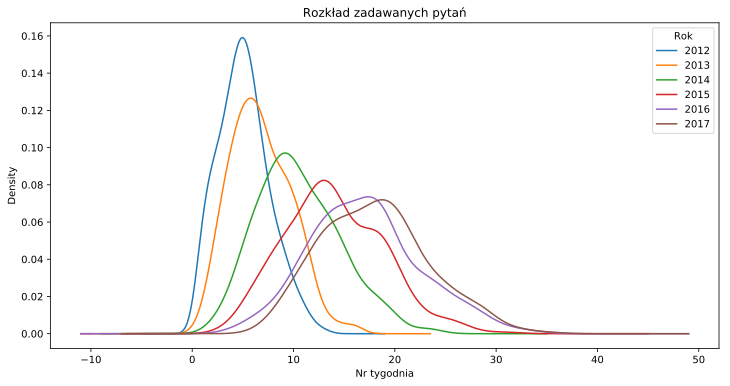

In [26]:
QuestionTable = pd.DataFrame()
for year in list(range(2012,2018)):
    Kolumna=(
    CSV["Posts"].query('PostTypeId == 1').query('PostTypeId == 1')
    .loc[CSV["Posts"]["CreationDate"].dt.year == year]
    .groupby([CSV["Posts"]["CreationDate"].dt.dayofyear]).size()
    )
    QuestionTable.insert((year-2012), (str(year)), Kolumna)
QuestionTable.columns.name = 'Rok'
ax=QuestionTable.plot(kind = 'kde', title = "Rozkład zadawanych pytań")
ax.set(xlabel="Nr tygodnia", ylabel="Density");


#### Odp. 1
Wakacyjny sezon wyjazdowy trwa mniej więcej między 27-35 tygodniem każdego roku. Jak widać na wykresie każdego kolejnego roku ludzie przygotowują się do podróży coraz później. Coraz popularniejsze są tanie oferty 'LastMinute'. Ponadto kurtoza rozkładu z roku na rok spada, co oznacza, że ludzie coraz częsciej podróżują poza sezonem wakacyjnym.

## <center>Popularność Krajów </center>

### Wydobycie listy krajów z jakiejś strony internetowej

In [27]:
 # Web Scraping - Lista Krajow na gicie
x = pd.read_html("https://gist.github.com/mlisovyi/e8df5c907a8250e14cc1e5933ed53ffd")
Kod = []
Kraj = []
Kontynent = [] 

# Zrobienie ze stringow list
for i in list(range(1,195)):
    Slowo = x[0][1][i]
    Kod.append (Slowo[(Slowo.find('code')+8):(Slowo.find('code')+10)])
    Kraj.append ( Slowo[(Slowo.find('name')+8):(Slowo.find('capital')-4)])
    Kontynent.append ( Slowo[(Slowo.find('continent')+13):(Slowo.find('name')-4)])

KrajMale = [x.lower() for x in Kraj]           # tagi sa malymi pisane
KontynentMale = [x.lower() for x in Kontynent]      # tagi sa malymi pisane

# Zrobienie ramki danych
Kraje=pd.DataFrame ({
    'Kraj' : Kraj,
    'Kod' : Kod,
    'Kontynent' : Kontynent,
    'KrajMale' : KrajMale,
    'KontynentMale' : KontynentMale
})
Kraje.head(10)


                  Kraj Kod      Kontynent             KrajMale  KontynentMale
0              Andorra  AD         Europe              andorra         europe
1          Afghanistan  AF           Asia          afghanistan           asia
2  Antigua and Barbuda  AG  North America  antigua and barbuda  north america
3              Albania  AL         Europe              albania         europe
4              Armenia  AM           Asia              armenia           asia
5               Angola  AO         Africa               angola         africa
6            Argentina  AR  South America            argentina  south america
7              Austria  AT         Europe              austria         europe
8            Australia  AU        Oceania            australia        oceania
9           Azerbaijan  AZ           Asia           azerbaijan           asia

### 10 Najpopularniejszych krajów na świecie

In [28]:
Kraje.at[ Kraje.loc[Kraje.Kod == "US",:] \
["KrajMale"].index[0]  , "KrajMale" ] = "usa"    #tagi 'usa' sa bardziej miarodajne niz 'United States of America'
Kraje.at[ Kraje.loc[Kraje.Kod == "GB",:]["KrajMale"].index[0]  , "KrajMale" ] = "uk"    #analogicznie GB niz United Kingdom
Kraje.at[ Kraje.loc[Kraje.Kod == "CN",:]["KrajMale"].index[0]  , "KrajMale" ] = "china"    #analogicznie China
Kraje.at[ Kraje.loc[Kraje.Kod == "ZA",:]["KrajMale"].index[0]  , "KrajMale" ] = "south-africa"    #analogicznie RPA

Najpopularniejsze = (
CSV["Tags"].merge(Kraje, left_on = 'TagName', right_on = 'KrajMale'). 
sort_values("Count", ascending = False)[["Count","Kraj"]] 
.reset_index(drop = True).rename(columns = {"Count" : 'IloscWspomnien'})
)
Najpopularniejsze.head(10)


   IloscWspomnien                        Kraj
0            3838               United States
1            3283              United Kingdom
2            1098                      Canada
3             846                     Germany
4             815                       India
5             740                      France
6             707                       Japan
7             587  People's Republic of China
8             523                   Australia
9             511                       Italy

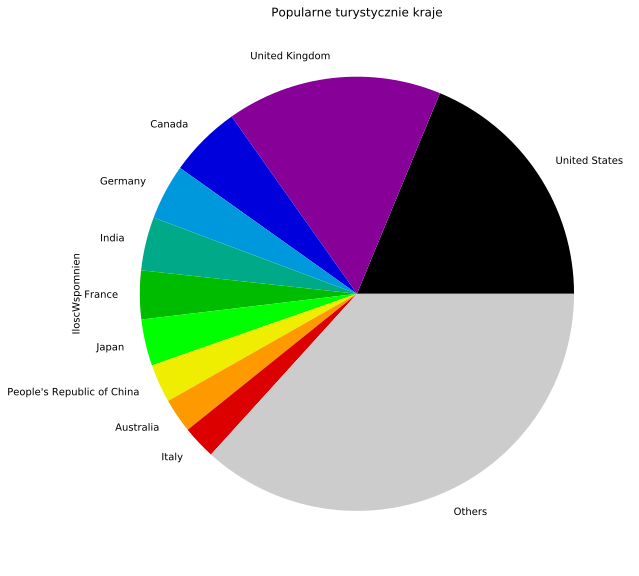

In [29]:
#Tworzenie wykresu                                       # Stworzenie ramki danych ze zsumowana krajami poza top10
Others=pd.DataFrame({"IloscWspomnien": Najpopularniejsze. \
iloc[10:,:].sum()[0], "Kraj": "Others"}, index=[0])              #zsumowanie wszystkich poza top 10

NajpopWykres = Najpopularniejsze.head(10).append(Others)        # Tabela Top10+Others

ax = NajpopWykres.set_index("Kraj").plot.pie(y = 'IloscWspomnien', \
figsize=(10, 10), legend = False, title = "Popularne turystycznie kraje", colormap = plt.get_cmap('nipy_spectral') )




### Pozycja Polski Na Swiecie

In [30]:
MiejscePol = Najpopularniejsze.loc[Najpopularniejsze["Kraj"] == 'Poland'].index[0]
IloscKrajowPow10 = Najpopularniejsze.query('IloscWspomnien > 10').count()[1]  # ilosc krajow powyzej 10 wspomnianych tagow
print ("Polska plasuje się na", MiejscePol, "miejscu, spośród", IloscKrajowPow10, "znaczących turystycznie krajów")

Polska plasuje się na 18 miejscu, spośród 95 znaczących turystycznie krajów


### 10 Najmniej popularnych krajów Europy

In [31]:
NajmniejPop = (
CSV["Tags"].merge(Kraje, left_on = 'TagName', right_on = 'KrajMale')
.query("Kontynent == 'Europe'")
.sort_values("Count", ascending = True)[["Count","Kraj"]] 
.reset_index(drop = True).rename(columns = {"Count" : 'IloscWspomnien'})
)
NajmniejPop.head(10)


   IloscWspomnien           Kraj
0               6        Andorra
1               7        Moldova
2              10         Monaco
3              10  Liechtenstein
4              15      Lithuania
5              16     Luxembourg
6              19         Latvia
7              24        Albania
8              26       Slovenia
9              26       Slovakia

### Popularność wybranego kraju

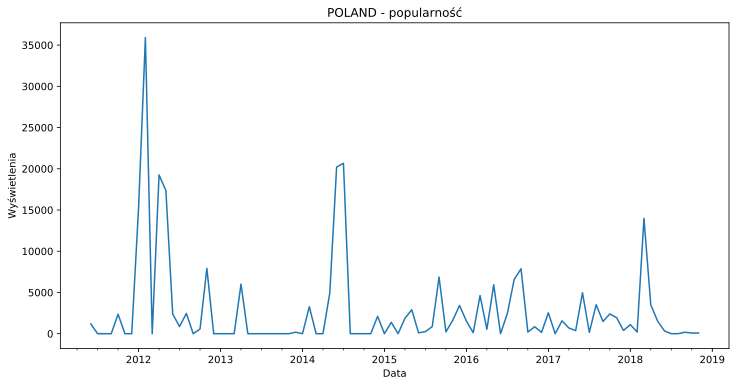

In [32]:
NazwaKraju = "poland"

TabelaSel = CSV["Posts"].loc[CSV["Posts"].Tags.str.contains(NazwaKraju).fillna(False)]
TabelaSel = TabelaSel.groupby(pd.Grouper(key='CreationDate', freq='1M')).sum()\
["ViewCount"]

ax = TabelaSel.plot(title = (NazwaKraju.upper()+" - popularność"));
ax.set(xlabel="Data", ylabel="Wyświetlenia");

Na przykładzie Polski, widać, ze szczyt popularności przypadak na czas rozgrywek Euro 2012, oraz siatkarskie mistrzostwa świata. Imprezy sportowe przyciągają największą ilość turystów.

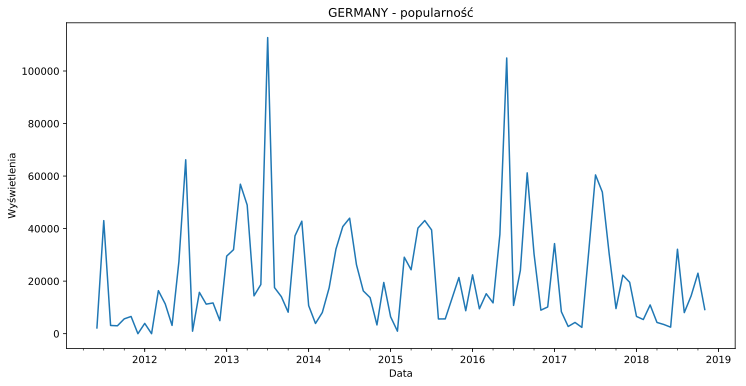

In [34]:
NazwaKraju = "germany"

TabelaSel = CSV["Posts"].loc[CSV["Posts"].Tags.str.contains(NazwaKraju).fillna(False)]
TabelaSel = TabelaSel.groupby(pd.Grouper(key='CreationDate', freq='1M')).sum()\
["ViewCount"]

ax = TabelaSel.plot(title = (NazwaKraju.upper()+" - popularność"));
ax.set(xlabel="Data", ylabel="Wyświetlenia");

Potwierdza to przykład z Niemiec i prawie 3x ilość wyświetleń w okresie Euro 2016